# Importing our Data 


In [1]:
import sqlite3
import pandas as pd 
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt 
%matplotlib inline 


In [2]:
#connecting to database 
conn = sqlite3.connect('calendly_data_test.db')
c = conn.cursor()

In [3]:
#list of all tables 
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]

In [4]:
tables

['users', 'event_types', 'calendar_types', 'events']

In [5]:
dfs = []
for i in tables:
    table = c.execute('SELECT * FROM "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    
    #make a string into variable name
    foo = i+"_df"
    exec(foo + " = df") # => TableName_df
    #keep all dataframe names in the list to remember what we have
    dfs.append(foo)

In [6]:
dfs

['users_df', 'event_types_df', 'calendar_types_df', 'events_df']

In [7]:
users_df.head()

,index,id,created_at,confirmed_at,company_role,referees_count,country_code
0,0,4256788,2019-01-01 01:56:23.466000,2019-01-01 01:56:33.251000,executive,0,US
1,1,4257052,2019-01-01 06:35:49.932000,2019-01-01 06:35:49.926000,executive,0,IN
2,2,4257200,2019-01-01 09:24:25.285000,2019-01-01 09:24:25.282000,executive,0,VN
3,3,4257314,2019-01-01 11:43:29.084000,2019-01-01 11:43:29.079000,sales_marketing,0,BR
4,4,4257666,2019-01-01 15:59:24.760000,2019-01-01 16:01:50.487000,other,0,US


In [8]:
event_types_df.head()

,index,user_id,organization_id,description,kind,max_booking_time,notification_type
0,0,4256842,None,None,solo,86400.0,calendar
1,1,4257060,None,None,solo,86400.0,calendar
2,2,4257108,None,None,solo,86400.0,calendar
3,3,4257154,None,None,solo,86400.0,calendar
4,4,4257236,None,None,solo,86400.0,calendar


In [9]:
calendar_types_df.head()

,index,user_id,created_at,calendar_type
0,0,4886704,2019-03-18 14:45:50.670000,outlook
1,1,5554602,2019-05-20 09:32:24.536000,outlook
2,2,4470228,2019-01-28 17:00:19.396000,outlook
3,3,4650574,2019-02-18 17:24:44.059000,google
4,4,4527860,2019-02-04 13:06:44.909000,google


In [10]:
events_df.head()

,index,id,user_id,cancelled,organization_id,created_at
0,0,87286910,4257474,0,6391995,2019-01-01 14:57:38.571000
1,1,87580836,4258380,0,6393354,2019-01-03 11:48:26.548000
2,2,87750928,4257044,0,6391350,2019-01-03 23:37:04.896000
3,3,88162942,4291770,0,6443514,2019-01-07 12:19:16.062000
4,4,87318462,4258636,1,6393738,2019-01-02 00:23:05.045000


# EDA


### `user_id` Breakdown by Tables:

- `users_df`: consists of 107,983 unique `id`
- `calendar_types_df`: consists of 65,464 unique `user_id`
- `events_df`: consists of 7,896 unique `user_id`


This tell us that there are registered users who are not active and users that do not have a calendar. 

# Data Navigation 
---

## Question: How many events have been scheduled in 2019? 


In [11]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115846 entries, 0 to 115845
Data columns (total 6 columns):
index              115846 non-null int64
id                 115846 non-null int64
user_id            115846 non-null int64
cancelled          115846 non-null int64
organization_id    115846 non-null int64
created_at         115846 non-null object
dtypes: int64(5), object(1)
memory usage: 5.3+ MB


In [12]:
events_df.tail()

,index,id,user_id,cancelled,organization_id,created_at
115841,115841,125807942,4258640,1,6393744,2019-06-26 14:24:10.734000
115842,115842,126720790,6067406,0,9110262,2019-07-01 13:07:34.778000
115843,115843,126793062,5465522,0,8206584,2019-07-01 16:35:11.984000
115844,115844,126837436,5889948,0,8843811,2019-07-01 18:32:06.755000
115845,115845,126844606,4769198,0,7160853,2019-07-01 18:51:34.178000


In [13]:
print(len(events_df[events_df.created_at.str.contains("2019")]))

115846


In [25]:
from datetime import datetime 

#creating function to convert to datetime 
def date_time(x):
    d = datetime.strptime(x, '%Y-%m-%d')
    return d

#creating function to determine how many days between signing up and scheduling an event 
def days_between(row): 
    return (row['event_date'] - row['sign_up_date']).days

In [26]:
import re 

#creating regex function to find date pattern 
def date_regex(x):
    d = re.compile(r'\d\d\d\d-\d\d-\d\d')
    mo = d.search(x)
    return mo.group()

In [ ]:
events_df['date'] = events_df.created_at.apply(date_regex).apply(date_time)

In [280]:
ee = events_df.groupby([pd.Grouper(key='date', freq='M')]).size().reset_index().sort_values('date')
ee.rename(columns={0:'#_of_monthly_events'}, inplace=True)
ee['month'] = ['Jan', 'Feb','Mar','Apr','May','Jun','Jul']
ee

In [285]:
eee = ee[['#_of_monthly_events', 'month']]
eee.set_index('month', inplace=True)
eee

,#_of_monthly_events
month,
Jan,9837
Feb,14158
Mar,19440
Apr,23034
May,24521
Jun,23347
Jul,1509


**Answer:** As of July 1, 2019 - 115,846 events were scheduled.

---


## Which registered user has completed the most events? 


In [14]:
events_df.head()

,index,id,user_id,cancelled,organization_id,created_at
0,0,87286910,4257474,0,6391995,2019-01-01 14:57:38.571000
1,1,87580836,4258380,0,6393354,2019-01-03 11:48:26.548000
2,2,87750928,4257044,0,6391350,2019-01-03 23:37:04.896000
3,3,88162942,4291770,0,6443514,2019-01-07 12:19:16.062000
4,4,87318462,4258636,1,6393738,2019-01-02 00:23:05.045000


In [107]:
#checking unique value counts 
print("Number of unique user_id:",len(events_df.user_id.value_counts()))
print('\n')
print('Top 5 Registered users with events scheduled')
events_df.user_id.value_counts().nlargest()

Number of unique user_id: 7896


Top 5 Registered users with events scheduled


4257478    935
4405664    772
5212162    671
4645160    592
4257592    592
Name: user_id, dtype: int64

In [16]:
#grouping scheduled events by user id
scheduled = events_df.groupby('user_id').size().reset_index()
scheduled.rename(columns={0: 'scheduled_events'}, inplace=True)

In [17]:
#creating a cancelled event df 
cancel_df = events_df[events_df.cancelled != 0]

In [18]:
#grouping cancelled events by user_id
cancel = cancel_df.groupby('user_id')['cancelled'].count().reset_index()

In [19]:
#merging datasets on user_id
most = pd.merge(scheduled, cancel, on='user_id')

#subtracting cancelled events from scheduled events 
most['completed_event'] = most.scheduled_events - most.cancelled

In [21]:
#setting user_id as index 
most.set_index('user_id', inplace=True)

In [123]:
print('Top 5 Registered users with completed events')
most.completed_event.nlargest()

Top 5 Registered users with completed events


user_id
4257478    732
4405664    693
5212162    607
4645160    536
5001568    527
Name: completed_event, dtype: int64

## Answer:
`user_id = 4257478 ` has completed the most events, at 732 events. 

**Note:** 3,379 users have not cancelled an event (4,526 users have cancelled at least one event) 

---

## How many registered users had their first event within a week of signing up? 

In [23]:
#merging datasets needed to answer question
all_df = pd.merge(users_df, events_df, left_on='id', right_on='user_id', left_index=True)
all_df.rename(columns={'created_at_x' : 'signed_up_at', 'created_at_y': 'event_created_at', 'id_y':'id',}, inplace=True)
all_df.drop(['index_x','id_x','index_y'], axis=1, inplace=True)

In [24]:
all_df.head()

,signed_up_at,confirmed_at,company_role,referees_count,country_code,id,user_id,cancelled,organization_id,event_created_at
135,2019-01-01 17:57:35.923000,2019-01-01 17:57:35.920000,other,0,US,93245450,4257926,0,6392673,2019-01-30 21:19:01.441000
1661,2019-01-01 17:57:35.923000,2019-01-01 17:57:35.920000,other,0,US,92785636,4257926,0,6392673,2019-01-29 10:10:14.039000
2617,2019-01-01 17:57:35.923000,2019-01-01 17:57:35.920000,other,0,US,93223688,4257926,1,6392673,2019-01-30 20:14:31.502000
2906,2019-01-01 17:57:35.923000,2019-01-01 17:57:35.920000,other,0,US,93244036,4257926,0,6392673,2019-01-30 21:14:31.847000
7003,2019-01-01 17:57:35.923000,2019-01-01 17:57:35.920000,other,0,US,92564670,4257926,0,6392673,2019-01-28 16:53:38.490000


In [269]:
#creating 
events_df['date'] = events_df.created_at.apply(date_regex).apply(date_time)
events_df.head()

,index,id,user_id,cancelled,organization_id,created_at,date
0,0,87286910,4257474,0,6391995,2019-01-01 14:57:38.571000,2019-01-01
1,1,87580836,4258380,0,6393354,2019-01-03 11:48:26.548000,2019-01-03
2,2,87750928,4257044,0,6391350,2019-01-03 23:37:04.896000,2019-01-03
3,3,88162942,4291770,0,6443514,2019-01-07 12:19:16.062000,2019-01-07
4,4,87318462,4258636,1,6393738,2019-01-02 00:23:05.045000,2019-01-02


In [27]:
#applying functions to dataset
all_df['sign_up_date'] = all_df.signed_up_at.apply(date_regex).apply(date_time)
all_df['event_date'] = all_df.event_created_at.apply(date_regex).apply(date_time)
all_df['day_btwn'] = all_df.apply(days_between, axis=1)

In [28]:
#selecting days_between 7 days or under (within a week of signing up)
week = all_df[all_df.day_btwn <= 7]

In [29]:
#grouping by user id and printing the length of the list
len(week.groupby('user_id')['day_btwn'].size().reset_index())

6443

In [30]:
#creating first event within a week of signing up df
first_week = week.groupby('user_id')['day_btwn'].size().reset_index().sort_values(by='day_btwn',ascending=False)
first_week.rename(columns={'day_btwn': '#_events_1st_week'}, inplace=True)
first_week.set_index('user_id').head(10)

,#_events_1st_week
user_id,
4526694,173
4348790,119
4943424,118
4405328,112
5890424,105
4827316,101
5212334,99
5377552,98
4405734,95


## Answer:
There are 6,443 or 5.96% registered users that had their first event within a week of signing up.

**Note:** Six registered users had more than 100 events scheduled within the first week of signing up. 

---

## What is the percentage breakout of Calendar types by registered users? (how many don't have a calendar?) 

In [31]:
calendar_types_df.head()

,index,user_id,created_at,calendar_type
0,0,4886704,2019-03-18 14:45:50.670000,outlook
1,1,5554602,2019-05-20 09:32:24.536000,outlook
2,2,4470228,2019-01-28 17:00:19.396000,outlook
3,3,4650574,2019-02-18 17:24:44.059000,google
4,4,4527860,2019-02-04 13:06:44.909000,google


In [132]:
print(calendar_types_df.calendar_type.value_counts())
print('\n')
calendar_types_df.isna().sum()

google             51457
outlook            11239
outlook_desktop     2153
icloud               615
Name: calendar_type, dtype: int64




index            0
user_id          0
created_at       0
calendar_type    0
dtype: int64

In [33]:
cal_type = calendar_types_df.groupby(['calendar_type'])['user_id'].size().reset_index()
cal_type['%_breakdown'] = round((cal_type.user_id / cal_type.user_id.sum())*100,2)

**Note:** After checking there are no duplicate user id's within the table `calendar_types_df`, the percentage breakout of calendar types of those with calendars are below. 

In [34]:
cal_type

,calendar_type,user_id,%_breakdown
0,google,51457,78.60
1,icloud,615,0.94
2,outlook,11239,17.17
3,outlook_desktop,2153,3.29


**Note:** Within users with calendar, 78% of users use google calendar. 


Let check how many registered users do not have a calendar. 

In [243]:
#merging users_df and calendar_types_df
cc = pd.merge(users_df, calendar_types_df, left_on='id', right_on='user_id', how='left')
cc.drop('user_id',axis=1, inplace=True)
cc.rename(columns={'id':'user_id'},inplace=True)
cc.calendar_type.fillna('None', inplace=True)

#grouping by calendar type
total_cal_type = cc.groupby(['calendar_type'])['user_id'].size().reset_index()
total_cal_type['%_breakdown'] = round((ccc.user_id / ccc.user_id.sum())*100,2)

In [244]:
total_cal_type

,calendar_type,user_id,%_breakdown
0,None,42519,39.38
1,google,51457,47.65
2,icloud,615,0.57
3,outlook,11239,10.41
4,outlook_desktop,2153,1.99


## Answer: 
There are 42,519 or 39% of total users without a calendar. 

---

## What is the average WoW (week over week) % change in signups for 2019? 

We'll start by checking the column names, data types and number of entries. Then we'll convert `created_at` to datetime in order to manipulate the data. Then we'll create a column `qty` so we can easily aggregrate by week.

In [35]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107983 entries, 0 to 107982
Data columns (total 7 columns):
index             107983 non-null int64
id                107983 non-null int64
created_at        107983 non-null object
confirmed_at      102621 non-null object
company_role      87985 non-null object
referees_count    107983 non-null int64
country_code      107869 non-null object
dtypes: int64(3), object(4)
memory usage: 5.8+ MB


In [36]:
users_df.head()

,index,id,created_at,confirmed_at,company_role,referees_count,country_code
0,0,4256788,2019-01-01 01:56:23.466000,2019-01-01 01:56:33.251000,executive,0,US
1,1,4257052,2019-01-01 06:35:49.932000,2019-01-01 06:35:49.926000,executive,0,IN
2,2,4257200,2019-01-01 09:24:25.285000,2019-01-01 09:24:25.282000,executive,0,VN
3,3,4257314,2019-01-01 11:43:29.084000,2019-01-01 11:43:29.079000,sales_marketing,0,BR
4,4,4257666,2019-01-01 15:59:24.760000,2019-01-01 16:01:50.487000,other,0,US


In [37]:
users_df['date'] = pd.to_datetime(users_df['created_at'])

In [38]:
users_df['qty'] = 1 

In [45]:
users_df.head()

,index,id,created_at,confirmed_at,company_role,referees_count,country_code,date,qty
0,0,4256788,2019-01-01 01:56:23.466000,2019-01-01 01:56:33.251000,executive,0,US,2019-01-01 01:56:23.466,1
1,1,4257052,2019-01-01 06:35:49.932000,2019-01-01 06:35:49.926000,executive,0,IN,2019-01-01 06:35:49.932,1
2,2,4257200,2019-01-01 09:24:25.285000,2019-01-01 09:24:25.282000,executive,0,VN,2019-01-01 09:24:25.285,1
3,3,4257314,2019-01-01 11:43:29.084000,2019-01-01 11:43:29.079000,sales_marketing,0,BR,2019-01-01 11:43:29.084,1
4,4,4257666,2019-01-01 15:59:24.760000,2019-01-01 16:01:50.487000,other,0,US,2019-01-01 15:59:24.760,1


In [67]:
#grouping number of user signups by week 'W'
wow = pd.DataFrame(users_df.set_index('date').resample('W')['qty'].sum())

In [69]:
wow['%_change'] = round((wow.qty.pct_change())*100, 4)

In [70]:
wow

,qty,%_change
date,,
2019-01-06,4001,NaN
2019-01-13,4001,0.0000
2019-01-20,3996,-0.1250
2019-01-27,4001,0.1251
2019-02-03,3998,-0.0750
2019-02-10,4001,0.0750
2019-02-17,4000,-0.0250
2019-02-24,4001,0.0250
2019-03-03,4001,0.0000


In [40]:
print(f'Week over week % change in signups for 2019: {round((wow.pct_change().mean())*100, 4)}%')

Week over week % change in signups for 2019: -0.0029%


## Answer:
The WoW % change in signups for 2019 is roughly -0.0029% or basically 0% 

---


# Data Presentation
---

## By calendar type, which cohort uses Calendly with the most intensity? Please provide: 
- A write up on how you quantified the intensity, with at least 2 visualizations
- Notes on why you suspected this behavior, and how you would use this information to guide product's direction

 

**We quantified intensity by:**
1. number of users 
2. number of events scheduled 
3. number of events scheduled within the first week of signing up and 
4. average events scheduled. 


In [41]:
#creating #_of_scheduled_events by user_id df
user_event_count = pd.DataFrame(events_df.user_id.value_counts())
user_event_count.reset_index(inplace=True)
user_event_count.head()
user_event_count.rename(columns={'index':'user_id', 'user_id':'#_of_schd_events'}, inplace=True)

In [51]:
user_event_count.head()

,user_id,#_of_schd_events
0,4257478,935
1,4405664,772
2,5212162,671
3,4645160,592
4,4257592,592


In [185]:
#merging neccessary datasets
m = pd.merge(cc,user_event_count ,on='user_id',how='left', left_index=True)
mm = pd.merge(m, first_week, on='user_id', how='left', left_index=True)

In [193]:
mm.reset_index(inplace=True)
mm.drop(['index','index_x'], axis=1, inplace=True)

In [198]:
df = mm[['user_id','calendar_type','#_of_schd_events','#_events_1st_week']]

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107983 entries, 0 to 107982
Data columns (total 4 columns):
user_id              107983 non-null int64
calendar_type        107983 non-null object
#_of_schd_events     7896 non-null float64
#_events_1st_week    6443 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ MB


In [209]:
#curious to see how many users scheduled over 500 events
df[df['#_of_schd_events'] >= 500]

,user_id,calendar_type,#_of_schd_events,#_events_1st_week
81451,4257592,outlook,592.0,81.0
82063,4405664,google,772.0,37.0
85701,5212162,google,671.0,45.0
104586,5001568,google,549.0,33.0
104892,4645160,outlook,592.0,NaN
107419,4257478,outlook,935.0,10.0


**Note:** It seems like the top 6 most used calendar type based on number of scheduled events, are split 50/50 between google and outlook. 

In [205]:
#curious to see how many users scheduled over 100 events within the first week of signing up 
df[df['#_events_1st_week'] >= 100]

,user_id,calendar_type,#_of_schd_events,#_events_1st_week
11236,4526694,google,205.0,173.0
21505,4827316,None,114.0,101.0
41726,4348790,google,189.0,119.0
55446,4405328,outlook,272.0,112.0
71555,4943424,google,169.0,118.0
107454,5890424,google,148.0,105.0


**Note:** 4/6 of the first 100 events scheduled within the first week of signing up belongs to users with google calendar.

In [234]:
first_week_groupby_cal = df.groupby(['calendar_type'])['#_events_1st_week'].count()
first_week_groupby_cal

calendar_type
None                476
google             4786
icloud              108
outlook             921
outlook_desktop     152
Name: #_events_1st_week, dtype: int64

In [210]:
g = pd.DataFrame(df.groupby(['calendar_type'])['#_of_schd_events'].count())
g.rename(columns={'#_of_schd_events':'user_id_count'}, inplace=True)

In [213]:
gg = pd.DataFrame(df.groupby(['calendar_type'])['#_of_schd_events'].sum())
gg.rename(columns={'#_of_schd_events':'scheduled_event'}, inplace=True)

In [216]:
intensity = pd.merge(g, gg, on='calendar_type', left_index=True)
intensity['avg_scheduled'] = round((intensity.user_id_count / intensity.scheduled_event)*100, 2)

In [222]:
intensity

,user_id_count,scheduled_event,avg_scheduled
calendar_type,,,
None,560,7183.0,7.80
google,5922,85562.0,6.92
icloud,139,2414.0,5.76
outlook,1094,17404.0,6.29
outlook_desktop,181,3283.0,5.51


**Note:** It seems like there are only 7,896 out of 107,983 registered users that have scheduled an event as of 2019. 

In [249]:
data = pd.merge(intensity, total_cal_type, on='calendar_type', left_index=True)

In [262]:
data.rename(columns={'user_id_count': 'active_user', 
                     'user_id':'total_user_id_count'}, inplace=True)
data['%_active_user'] = round((data.active_user / data.total_user_id_count)*100,2)
data['total_%_active_user'] = round((data.active_user / data.active_user.sum())*100,2)
data['total_%_user'] = round((data.active_user / data.total_user_id_count.sum())*100,2)

In [264]:
data.set_index('calendar_type',inplace=True)
data

,active_user,scheduled_event,avg_scheduled,total_user_id_count,%_breakdown,%_active_user,total_%_active_user,total_%_user
calendar_type,,,,,,,,
None,560,7183.0,7.80,42519,39.38,1.32,7.09,0.52
google,5922,85562.0,6.92,51457,47.65,11.51,75.00,5.48
icloud,139,2414.0,5.76,615,0.57,22.60,1.76,0.13
outlook,1094,17404.0,6.29,11239,10.41,9.73,13.86,1.01
outlook_desktop,181,3283.0,5.51,2153,1.99,8.41,2.29,0.17


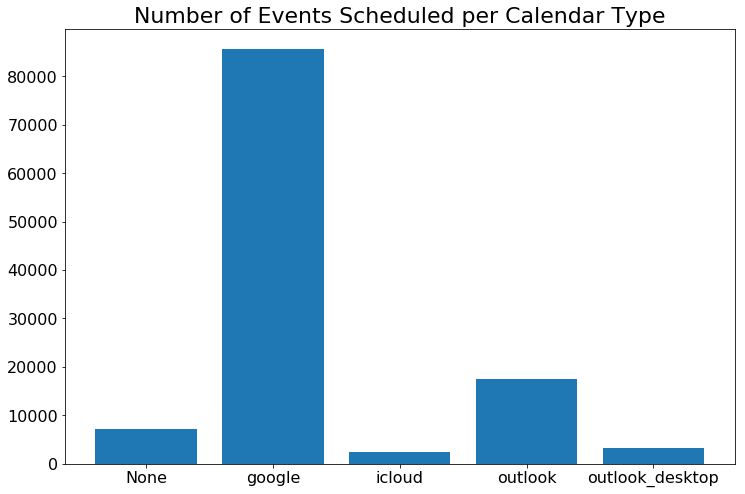

In [247]:
x = intensity.index

plt.figure(figsize=(12,8))
plt.bar(x, intensity.scheduled_event)
plt.title('Number of Events Scheduled per Calendar Type' , fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

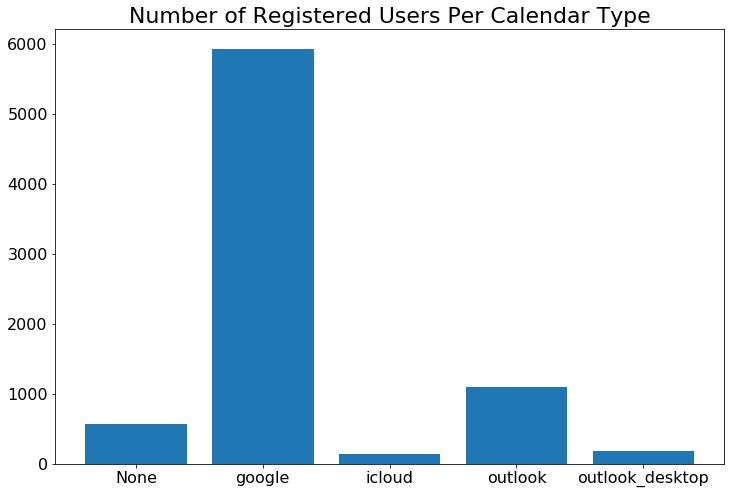

In [225]:
plt.figure(figsize=(12,8))
plt.bar(x, intensity.user_id_count)
plt.title('Number of Registered Users Per Calendar Type' , fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

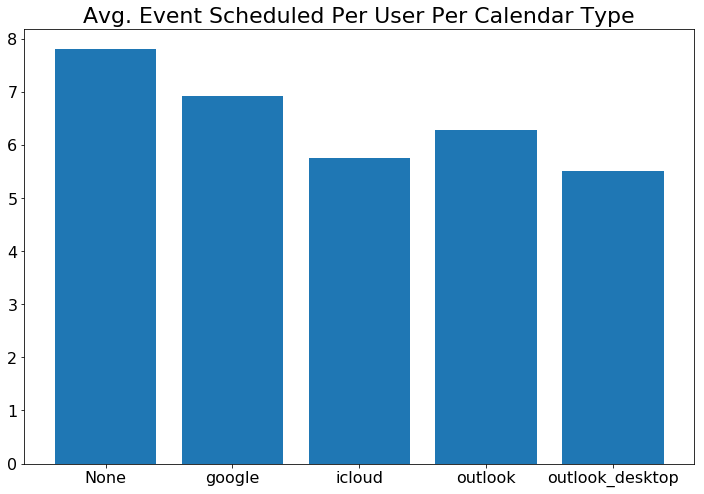

In [226]:
plt.figure(figsize=(12,8))
plt.bar(x, intensity.avg_scheduled)
plt.title('Avg. Event Scheduled Per User Per Calendar Type' , fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

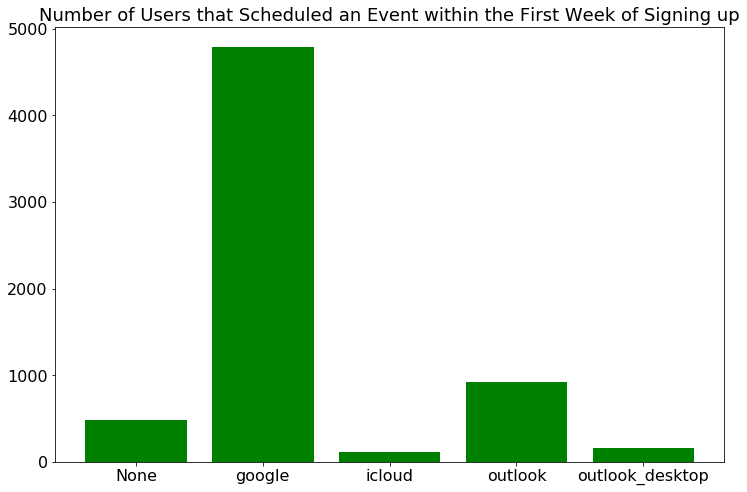

In [266]:

plt.figure(figsize=(12,8))
plt.bar(x, first_week_groupby_cal, color='green')
plt.title('Number of Users that Scheduled an Event within the First Week of Signing up' , fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [265]:
data

,active_user,scheduled_event,avg_scheduled,total_user_id_count,%_breakdown,%_active_user,total_%_active_user,total_%_user
calendar_type,,,,,,,,
None,560,7183.0,7.80,42519,39.38,1.32,7.09,0.52
google,5922,85562.0,6.92,51457,47.65,11.51,75.00,5.48
icloud,139,2414.0,5.76,615,0.57,22.60,1.76,0.13
outlook,1094,17404.0,6.29,11239,10.41,9.73,13.86,1.01
outlook_desktop,181,3283.0,5.51,2153,1.99,8.41,2.29,0.17


**We quantified intensity by:**
1. number of users 
2. number of events scheduled 
3. number of events scheduled within the first week of signing up 
4. average events scheduled

**Observations**: 
1. Calendar type = `google`, has the most:
    - registered users 
    - events scheduled
    - users that scheduled an event within the first week of signing up
    - highest percentage of total active users
2. Calendar type = `None` i.e. users without a calendar, has the highest average event scheduled per user. 

Based on our findings above, we concluded calendar type google uses Calendly with the most intensity.

**Recomendations:** 
1. Service accounts/users that uses google calendar to increase conversion rate from free users to paid users: 
    - provide excellent customer service - through user friendly people, process, products. 
    - provide add-ons (i.e. integration), that magnify Calendly's ability to execute better than competitors. 
2. Increase useability for Outlook calendar in order to increase amount of users.
3. Recommend users w/o calendars to use either google or outlook calendar. 
    

## 2. Given your time working with the data set, 
1) what is something that you would like to spend more time digging into?

A: Provided the data, we'd be curious to see how many of the active users are: 
    - Basic, Premium, and Pro
    - Utilize the features provided
    - Which features are used the most

2) what do you expect to find upon further exploration? 

A: Based on the data provided, we'd expect calendar type google to have the most quantity of paid accounts. 

Please provide: 
- Written answer to the two questions above 
- Any data/visualizations highlighting your curiosity